In [1]:
import os
from pathlib import Path
import pandas as pd

In [4]:
DirPpath = Path(os.path.abspath('')).parent # Fetching the current directory path - Specific for ipynb file - For .py: Path(os.path.dirname(os.path.realpath(__file__)).replace("\\", "/"))

PledgesCsvPath = str(DirPpath.absolute()) + "/CleanedData.csv"  

In [5]:
PledgesDf = pd.read_csv(PledgesCsvPath, index_col=0)

In [6]:
import string
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [7]:
def first_clean(text):
    return " ".join(text.split()).replace("_x000D_","")

first_clean(PledgesDf.iloc[3,1]) # Delete the returns from excel

'Achieve sustainable and flexible solutions for multimodal transport and develop policies to protect natural heritage and biodiversity, respecting the socio-cultural authenticity of host communities.  CNA Turismo e Commercio, over the three-year period (between autumn 2022 and throughout 2023), will organize training seminars for businesses - with the involvement of public and private stakeholders - aimed at the implementation of concrete solutions for the development of good practices for a supply of multimodal transport and protocols for the respect and protection of the natural heritage and biodiversity.'

In [8]:
def preprocess(text):
    text = text.lower() # Lowercase all the characters from the string
    text = text.strip() # Remove the leading and trailing whitespaces
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) # Removing Punctuation
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text)) # Remove non alphanumeric characters
    text = re.sub(r'\d', '', text) # Removing digits
    text = re.sub(r'\s+', ' ', str(text).strip()) # Replacing "double, triple, etc" whitespaces by one
    return text

preprocess(first_clean(PledgesDf.iloc[3,1]))

'achieve sustainable and flexible solutions for multimodal transport and develop policies to protect natural heritage and biodiversity respecting the socio cultural authenticity of host communities cna turismo e commercio over the three year period between autumn and throughout will organize training seminars for businesses with the involvement of public and private stakeholders aimed at the implementation of concrete solutions for the development of good practices for a supply of multimodal transport and protocols for the respect and protection of the natural heritage and biodiversity'

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [9]:
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

stopword(preprocess(first_clean(PledgesDf.iloc[3,1])))

'achieve sustainable flexible solutions multimodal transport develop policies protect natural heritage biodiversity respecting socio cultural authenticity host communities cna turismo e commercio three year period autumn throughout organize training seminars businesses involvement public private stakeholders aimed implementation concrete solutions development good practices supply multimodal transport protocols respect protection natural heritage biodiversity'

In [10]:
# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()


# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(string))  # Get position tags
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in
         enumerate(word_pos_tags)]  # Map the position tag and lemmatize the word/token
    return " ".join(a)

lemmatizer(stopword(preprocess(first_clean(PledgesDf.iloc[3,1]))))

'achieve sustainable flexible solution multimodal transport develop policy protect natural heritage biodiversity respect socio cultural authenticity host community cna turismo e commercio three year period autumn throughout organize training seminar business involvement public private stakeholder aim implementation concrete solution development good practice supply multimodal transport protocol respect protection natural heritage biodiversity'

In [11]:
def preprocessing(text):

    global n
    n = n +1
    
    print("**************")
    print("n is : ")
    print(n)
    print("length of the text is : ")
    print(len(first_clean(text)))
    return lemmatizer(stopword(preprocess(first_clean(text))))

In [12]:
n=0
print("begin pre-processing")
PledgesDf['clean_text'] = PledgesDf['Pledge'].apply(lambda x: preprocessing(x))
print("end pre-processing")

begin pre-processing
**************
n is : 
1
length of the text is : 
1461
**************
n is : 
2
length of the text is : 
953
**************
n is : 
3
length of the text is : 
273
**************
n is : 
4
length of the text is : 
613
**************
n is : 
5
length of the text is : 
2515
**************
n is : 
6
length of the text is : 
249
**************
n is : 
7
length of the text is : 
304
**************
n is : 
8
length of the text is : 
1125
**************
n is : 
9
length of the text is : 
640
**************
n is : 
10
length of the text is : 
352
**************
n is : 
11
length of the text is : 
130
**************
n is : 
12
length of the text is : 
2676
**************
n is : 
13
length of the text is : 
266
**************
n is : 
14
length of the text is : 
2442
**************
n is : 
15
length of the text is : 
361
**************
n is : 
16
length of the text is : 
2586
**************
n is : 
17
length of the text is : 
1031
**************
n is : 
18
length of the text i

In [13]:
PledgesDf.head()

,Topic,Pledge,clean_text
0,1,HOTREC calls for a level playing field and fai...,hotrec call level play field fair competition ...
1,1,Actually we as an association are still pretty...,actually association still pretty much begin d...
2,1,Estonia sees the need to synchronize and harmo...,estonia see need synchronize harmonize rule sh...
3,2,Achieve sustainable and flexible solutions for...,achieve sustainable flexible solution multimod...
4,2,The Ile-de-France Region aims to make tourist ...,ile de france region aim make tourist site acc...


In [14]:
tokens = [nltk.word_tokenize(i) for i in PledgesDf["clean_text"]]

In [15]:
word_freq = {}
for sent in tokens:
    for i in sent:

        if i not in word_freq.keys():
            word_freq[i] = 1
        else:
            word_freq[i] += 1
len(word_freq)

3853

In [16]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['tourism',
 'sustainable',
 'destination',
 'de',
 'development',
 'data',
 'project',
 'support',
 'sustainability',
 'sector']

### Sort the french pledges out of the dataset

In [17]:
import gensim
from gensim.models import Word2Vec

In [18]:
# Setting the model with its hyperparameters
model = Word2Vec(sentences = tokens, vector_size=100, window = 5)

In [19]:
model.wv.get_vector("hotrec")

array([-3.6172554e-02,  5.2524917e-02,  3.5431921e-02,  1.0510127e-02,
       -6.2836786e-03, -8.4535956e-02,  2.9099386e-02,  1.0518078e-01,
       -2.1853076e-02, -1.0511017e-02, -3.0883837e-02, -6.0128171e-02,
        8.5032952e-05,  2.0843133e-02, -1.3340164e-02, -6.0335904e-02,
       -3.2188206e-03, -8.3810121e-02, -3.3489812e-02, -6.1259195e-02,
        3.8399424e-02,  3.8736533e-02,  4.4951912e-02, -2.9466523e-02,
       -1.9976156e-02, -8.5787000e-03, -4.5707610e-02, -4.0439911e-02,
       -1.3481074e-02,  1.7987676e-02,  4.6854675e-02,  4.3902262e-03,
        1.8248726e-02,  4.0026824e-03, -2.5508625e-02,  6.2657274e-02,
        2.7667258e-03, -5.1125091e-02, -1.9912614e-02, -9.0936467e-02,
        1.6590515e-02, -2.9812468e-02, -2.8684713e-02, -8.6641805e-03,
        5.7395838e-02, -9.5247645e-03, -3.4057520e-02, -1.4094895e-02,
        3.0900929e-02,  1.1455970e-02,  2.2274009e-03, -5.2720357e-02,
        3.3030294e-02, -1.9333022e-02, -4.3293361e-02,  4.3351371e-02,
      

In [20]:
model.wv.most_similar(positive = ["sustainable"])

[('tourism', 0.9997872114181519),
 ('sustainability', 0.9997749328613281),
 ('destination', 0.9997649788856506),
 ('travel', 0.9997619390487671),
 ('action', 0.9997507929801941),
 ('strategy', 0.9997501373291016),
 ('use', 0.9997497200965881),
 ('measure', 0.9997482299804688),
 ('project', 0.9997478127479553),
 ('plan', 0.9997439980506897)]

### Visualiser les mots avec PCA ou t-sn

In [30]:
import sklearn
from sklearn import decomposition

In [31]:
X = model.wv.vectors

In [42]:
pca = decomposition.PCA(n_components=1)
results = pca.fit_transform(X)

In [43]:
pca.fit_transform(X)

array([[ 3.380396  ],
       [ 2.8399494 ],
       [ 2.8893087 ],
       ...,
       [-0.6723625 ],
       [-0.6414903 ],
       [-0.83299977]], dtype=float32)

In [44]:
pca.explained_variance_ratio_

array([0.9951303], dtype=float32)

In [45]:
import matplotlib.pyplot as plt

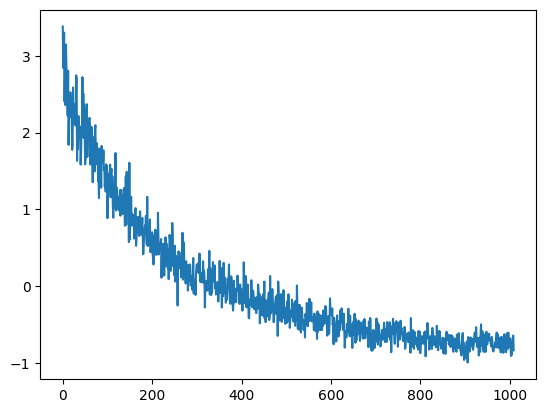

In [50]:
plt.plot(results[:,0])

In [54]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

In [60]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

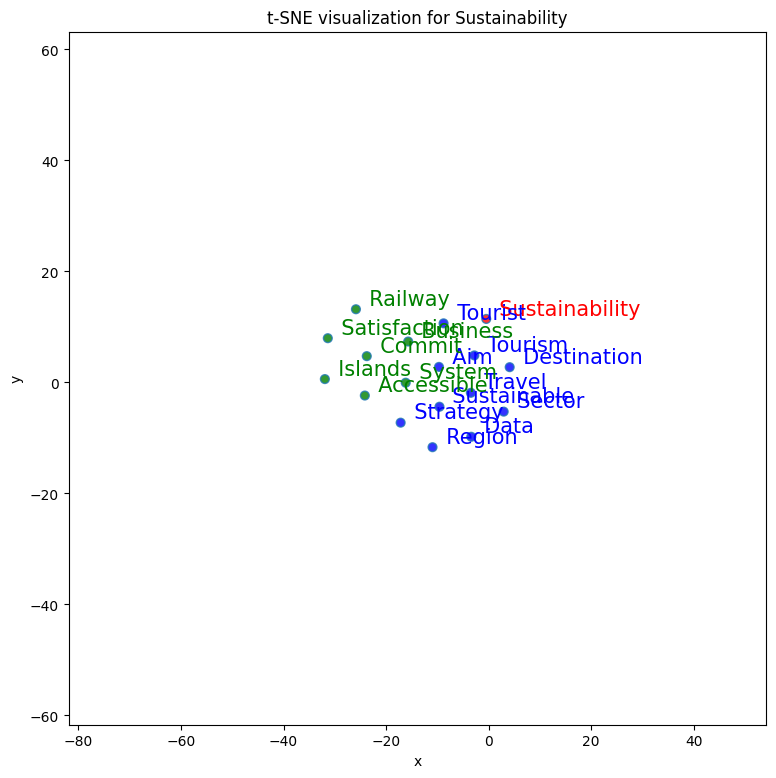

In [63]:
tsnescatterplot(model, 'sustainability', ['commit', 'accessible', 'railway', 'satisfaction', 'business', 'system', 'islands'])

In [23]:
import numpy as np

In [22]:
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [24]:
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
vectors_w2v = modelw.transform(tokens)

print(vectors_w2v)

[[-0.12560223  0.23184161  0.15681297 ... -0.2639868   0.09877244
  -0.09417447]
 [-0.14467603  0.2658919   0.18210404 ... -0.3050768   0.11311968
  -0.10659759]
 [-0.133623    0.25393614  0.17204833 ... -0.29037616  0.10742884
  -0.10489351]
 ...
 [-0.17307088  0.32190362  0.21772222 ... -0.36497992  0.13521887
  -0.12980379]
 [-0.15961476  0.29458204  0.20010252 ... -0.3362451   0.12484045
  -0.11860909]
 [-0.14230888  0.2624757   0.18064186 ... -0.30391672  0.11278331
  -0.10682324]]


### Visualiser les documents avec PCA

In [27]:
import gensim.downloader as api

In [ ]:
wv2 = api.load('word2vec-google-news-300')

In [ ]:
wv2.most_similar(positive=["hotrec"])

In [ ]:
w2v2 = dict(zip(wv2.wv.index_to_key, wv2.wv.vectors))
modelw2 = MeanEmbeddingVectorizer(w2v2)

# converting text to numerical data using Word2Vec
vectors_w2v2 = modelw2.transform(tokens)

print(vectors_w2v2)